<a href="https://colab.research.google.com/github/tylerlum/ufc_automated_scoring_system/blob/RoughWork/UFC_automated_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UFC Automated Scoring

The goal of this notebook is to:
* Read in stored, scraped UFC data and convert it into a dataset ready for ML models
* Train, test, and analyze ML models

Functional as of April 2021

## Read in stored data

In [1343]:
import numpy as np
import pandas as pd

In [1344]:
STORED_FIGHT_TABLE = pd.read_csv('FIGHT_TABLE_NUM_EVENTS_All_DATA_MODE_Summary_22-04-2021_11:08:22.csv')

In [1345]:
STORED_FIGHT_TABLE

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,150,62,52.0,29.0,169,70,4,1,57.0,20.0,0,0,0,0,259.0,26.0,Robert Whittaker,Kelvin Gastelum,115,42,13,7,22,13,138,59,5,3,7,0,0,U-DEC
1,0,0,105,88,47.0,45.0,109,99,0,0,NaN,NaN,0,0,0,0,39.0,0.0,Andrei Arlovski,Chase Sherman,54,55,26,16,25,17,103,84,2,4,0,0,0,U-DEC
2,0,0,21,27,44.0,49.0,32,91,0,8,NaN,33.0,0,2,0,0,2.0,701.0,Abdul Razak Alhassan,Jacob Malkoun,11,24,9,2,1,1,14,18,5,3,2,6,1,U-DEC
3,0,1,66,55,58.0,46.0,84,72,3,0,60.0,0.0,1,0,0,0,386.0,38.0,Tracy Cortez,Justine Kish,40,30,19,8,7,17,39,50,7,4,20,1,0,S-DEC
4,0,0,90,80,46.0,47.0,90,82,0,4,NaN,44.0,0,0,0,0,3.0,141.0,Luis Pena,Alexander Munoz,74,40,12,20,4,20,88,77,2,3,0,0,0,S-DEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5888,2,0,24,16,68.0,33.0,49,31,0,1,NaN,50.0,0,0,0,0,NaN,NaN,Pedro Rizzo,David Abbott,12,16,0,0,12,0,17,7,4,4,3,5,0,KO/TKO Punch
5889,0,0,19,24,55.0,55.0,95,145,1,2,11.0,100.0,0,2,0,1,NaN,NaN,Pat Miletich,Mikey Burnett,2,2,12,20,5,2,4,1,15,23,0,0,0,S-DEC
5890,0,0,14,13,35.0,19.0,30,15,3,0,60.0,NaN,5,0,1,0,NaN,NaN,Tsuyoshi Kohsaka,Pete Williams,7,6,4,7,3,0,11,12,0,1,3,0,0,U-DEC
5891,0,0,9,3,56.0,60.0,17,11,1,0,100.0,NaN,1,0,0,0,NaN,NaN,Ebenezer Fontes Braga,Jeremy Horn,6,0,1,3,2,0,2,0,5,3,2,0,0,SUB Guillotine Choke


In [1346]:
# Clean dataset: Only decisions with clear winners
STORED_FIGHT_TABLE = STORED_FIGHT_TABLE[STORED_FIGHT_TABLE["Method"].str.contains("DEC")]
STORED_FIGHT_TABLE = STORED_FIGHT_TABLE[(STORED_FIGHT_TABLE["Winner"] == 1) | (STORED_FIGHT_TABLE["Winner"] == 0)]
STORED_FIGHT_TABLE

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
0,0,0,150,62,52.0,29.0,169,70,4,1,57.0,20.0,0,0,0,0,259.0,26.0,Robert Whittaker,Kelvin Gastelum,115,42,13,7,22,13,138,59,5,3,7,0,0,U-DEC
1,0,0,105,88,47.0,45.0,109,99,0,0,NaN,NaN,0,0,0,0,39.0,0.0,Andrei Arlovski,Chase Sherman,54,55,26,16,25,17,103,84,2,4,0,0,0,U-DEC
2,0,0,21,27,44.0,49.0,32,91,0,8,NaN,33.0,0,2,0,0,2.0,701.0,Abdul Razak Alhassan,Jacob Malkoun,11,24,9,2,1,1,14,18,5,3,2,6,1,U-DEC
3,0,1,66,55,58.0,46.0,84,72,3,0,60.0,0.0,1,0,0,0,386.0,38.0,Tracy Cortez,Justine Kish,40,30,19,8,7,17,39,50,7,4,20,1,0,S-DEC
4,0,0,90,80,46.0,47.0,90,82,0,4,NaN,44.0,0,0,0,0,3.0,141.0,Luis Pena,Alexander Munoz,74,40,12,20,4,20,88,77,2,3,0,0,0,S-DEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5880,0,0,27,19,38.0,21.0,71,21,3,1,100.0,16.0,0,1,0,0,NaN,NaN,Pat Miletich,Jorge Patino,9,5,4,1,14,13,20,16,2,2,5,1,0,U-DEC
5881,0,0,16,25,55.0,47.0,29,58,0,2,NaN,33.0,0,0,0,0,NaN,NaN,Pedro Rizzo,Mark Coleman,9,23,0,0,7,2,15,7,1,0,0,18,0,S-DEC
5883,1,0,42,34,31.0,53.0,57,41,0,0,NaN,0.0,1,0,0,0,NaN,NaN,Mikey Burnett,Townsend Saunders,28,7,9,14,5,13,21,20,19,14,2,0,0,U-DEC
5889,0,0,19,24,55.0,55.0,95,145,1,2,11.0,100.0,0,2,0,1,NaN,NaN,Pat Miletich,Mikey Burnett,2,2,12,20,5,2,4,1,15,23,0,0,0,S-DEC


In [1347]:
fighter0 = "TJ Dillashaw"
fighter1 = "Dominick Cruz"

In [1348]:
controversial = STORED_FIGHT_TABLE[(STORED_FIGHT_TABLE["Fighter 0 Name"] == fighter0) & (STORED_FIGHT_TABLE["Fighter 1 Name"] == fighter1)]
without_controversial = STORED_FIGHT_TABLE.drop(index=controversial.index)

In [1349]:
controversial

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
2520,0,0,109,112,26.0,37.0,130,122,1,4,12.0,36.0,0,0,0,0,72.0,33.0,TJ Dillashaw,Dominick Cruz,64,97,22,9,23,6,102,107,6,5,1,0,1,S-DEC


In [1350]:
without_controversial[(without_controversial["Fighter 0 Name"] == fighter0) & (without_controversial["Fighter 1 Name"] == fighter1)]

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method


In [1351]:
X_train = without_controversial.drop(['Winner', 'Fighter 0 Name', 'Fighter 1 Name', 'Method'], axis=1).fillna(0)
y_train = without_controversial[['Winner']]

In [1352]:
X_valid = controversial.drop(['Winner', 'Fighter 0 Name', 'Fighter 1 Name', 'Method'], axis=1).fillna(0)
y_valid = controversial[['Winner']]

In [1353]:
X_train.head()

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
0,0,0,150,62,52.0,29.0,169,70,4,1,57.0,20.0,0,0,0,0,259.0,26.0,115,42,13,7,22,13,138,59,5,3,7,0
1,0,0,105,88,47.0,45.0,109,99,0,0,0.0,0.0,0,0,0,0,39.0,0.0,54,55,26,16,25,17,103,84,2,4,0,0
2,0,0,21,27,44.0,49.0,32,91,0,8,0.0,33.0,0,2,0,0,2.0,701.0,11,24,9,2,1,1,14,18,5,3,2,6
3,0,1,66,55,58.0,46.0,84,72,3,0,60.0,0.0,1,0,0,0,386.0,38.0,40,30,19,8,7,17,39,50,7,4,20,1
4,0,0,90,80,46.0,47.0,90,82,0,4,0.0,44.0,0,0,0,0,3.0,141.0,74,40,12,20,4,20,88,77,2,3,0,0


In [1354]:
y_train.head()

,Winner
0,0
1,0
2,1
3,0
4,0


In [1355]:
X_valid.head()

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
2520,0,0,109,112,26.0,37.0,130,122,1,4,12.0,36.0,0,0,0,0,72.0,33.0,64,97,22,9,23,6,102,107,6,5,1,0


In [1356]:
y_valid.head()

,Winner
2520,1


## Setup train/validate/test split with data augmentation

TODO: Add in smarter data augmentation that create new datapoints nearby.

In [1357]:
def create_flipped_table(table):
    '''Rearranges columns of table so that each fight has two rows. Let fighters be A and B.
       One row has (Fighter 0 = A, Fighter 1 = B). One row has (Fighter 0 = B, Fighter 1 = A)
       Ensure same column order, as column names not looked at when passed to ML model'''

    # Get columns in flipped order, which moves the columns around, but changes column name order too
    flipped_columns = []
    for column in table.columns:
        if "Fighter 0" in column:
            flipped_columns.append(column.replace("Fighter 0", "Fighter 1"))
        elif "Fighter 1" in column:
            flipped_columns.append(column.replace("Fighter 1", "Fighter 0"))
        else:
            flipped_columns.append(column)
    flipped_table = table[flipped_columns]

    # Flips winners around
    if 'Winner' in flipped_table.columns:
         flipped_table['Winner'] = flipped_table['Winner'].replace([0, 1], [1, 0])

    # Change column names back to normal
    flipped_table.columns = table.columns
    return flipped_table


def add_rows_of_flipped_columns(table):
    flipped_table = create_flipped_table(table)
    new_table = pd.concat([table, flipped_table])
    return new_table

In [1358]:
# Add flipped rows so fighter 0 and 1 are treated same
X_train, y_train = add_rows_of_flipped_columns(X_train), add_rows_of_flipped_columns(y_train)
X_valid, y_valid = add_rows_of_flipped_columns(X_valid), add_rows_of_flipped_columns(y_valid)

In [1359]:
# Expect equal number of examples in Fighter 0 as Fighter 1 from data augmentation
assert(len(y_train[y_train['Winner'] == 0]) == len(y_train[y_train['Winner'] == 1]))
assert(len(y_valid[y_valid['Winner'] == 0]) == len(y_valid[y_valid['Winner'] == 1]))


In [1360]:
X_train

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground
0,0,0,150,62,52.0,29.0,169,70,4,1,57.0,20.0,0,0,0,0,259.0,26.0,115,42,13,7,22,13,138,59,5,3,7,0
1,0,0,105,88,47.0,45.0,109,99,0,0,0.0,0.0,0,0,0,0,39.0,0.0,54,55,26,16,25,17,103,84,2,4,0,0
2,0,0,21,27,44.0,49.0,32,91,0,8,0.0,33.0,0,2,0,0,2.0,701.0,11,24,9,2,1,1,14,18,5,3,2,6
3,0,1,66,55,58.0,46.0,84,72,3,0,60.0,0.0,1,0,0,0,386.0,38.0,40,30,19,8,7,17,39,50,7,4,20,1
4,0,0,90,80,46.0,47.0,90,82,0,4,0.0,44.0,0,0,0,0,3.0,141.0,74,40,12,20,4,20,88,77,2,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5880,0,0,19,27,21.0,38.0,21,71,1,3,16.0,100.0,1,0,0,0,0.0,0.0,5,9,1,4,13,14,16,20,2,2,1,5
5881,0,0,25,16,47.0,55.0,58,29,2,0,33.0,0.0,0,0,0,0,0.0,0.0,23,9,0,0,2,7,7,15,0,1,18,0
5883,0,1,34,42,53.0,31.0,41,57,0,0,0.0,0.0,0,1,0,0,0.0,0.0,7,28,14,9,13,5,20,21,14,19,0,2
5889,0,0,24,19,55.0,55.0,145,95,2,1,100.0,11.0,2,0,1,0,0.0,0.0,2,2,20,12,2,5,1,4,23,15,0,0


In [1361]:
y_train

,Winner
0,0
1,0
2,1
3,0
4,0
...,...
5880,1
5881,1
5883,1
5889,1


In [1362]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_valid.shape = {X_valid.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_valid.shape = {y_valid.shape}")


X_train.shape = (5368, 30)
X_valid.shape = (2, 30)
y_train.shape = (5368, 1)
y_valid.shape = (2, 1)


### Standardize features and break into fighter 0 and 1

In [1363]:
fighter0_columns = [col for col in X_train.columns if "Fighter 0" in col]
fighter1_columns = [col for col in X_train.columns if "Fighter 1" in col]

X0_train = X_train[fighter0_columns]
X1_train = X_train[fighter1_columns]
X0_valid = X_valid[fighter0_columns]
X1_valid = X_valid[fighter1_columns]

X_train_new = pd.concat([X0_train, X1_train], axis=1)
X_valid_new = pd.concat([X0_valid, X1_valid], axis=1) 

means, stds = X_train_new.mean(), X_train_new.std()
X_train_new_normal = (X_train_new - means) / stds
X_valid_new_normal = (X_valid_new - means) / stds

## Define inputs to future training

In [1364]:
# X_train, y_train = X_train_new_normal_aug, y_train_aug
X_train = X_train_new_normal
X_valid = X_valid_new_normal

## Train and test ML models

TODO: Play around with PyTorch, add in data augmentation like SMOTE, see if normalizing, standardizing, extracting difference features helps. Must be done for deep models. Try out PCA or MDS to visualize.

In [1365]:
import matplotlib.pyplot as plt


In [1366]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def get_predIdxs_and_trueIdxs(classifier, X, y):
    predIdxs = np.where(classifier.predict(X) > 0.5, 1, 0)
    trueIdxs = y
    return predIdxs, trueIdxs

def plot_confusion_matrix(classifier, X, y):
    predIdxs, trueIdxs = get_predIdxs_and_trueIdxs(classifier, X, y)
    cm = confusion_matrix(trueIdxs, predIdxs)
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fighter 0 Win", "Fighter 1 Win"])
    cmDisplay.plot()
    
def print_classification_report(classifier, X, y):
    predIdxs, trueIdxs = get_predIdxs_and_trueIdxs(classifier, X, y)
    print(classification_report(trueIdxs, predIdxs, target_names=["Fighter 0 Win", "Fighter 1 Win"]))

### Decision Tree

accuracy_train = 1.0
accuracy_valid = 1.0


<BarContainer object of 30 artists>

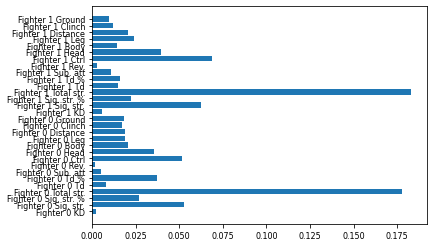

In [1367]:
from sklearn.tree import DecisionTreeClassifier
# Train
decision_tree_clf = DecisionTreeClassifier(random_state=0)
decision_tree_clf.fit(X_train, y_train)

# Validate
accuracy_train = decision_tree_clf.score(X_train, y_train)
accuracy_valid = decision_tree_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, decision_tree_clf.feature_importances_)

               precision    recall  f1-score   support

Fighter 0 Win       1.00      1.00      1.00         1
Fighter 1 Win       1.00      1.00      1.00         1

     accuracy                           1.00         2
    macro avg       1.00      1.00      1.00         2
 weighted avg       1.00      1.00      1.00         2



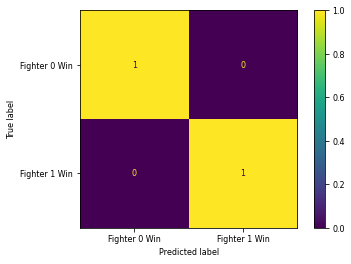

In [1368]:
plot_confusion_matrix(decision_tree_clf, X_valid, y_valid)
print_classification_report(decision_tree_clf, X_valid, y_valid)

### Random forest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


accuracy_train = 0.8714605067064084
accuracy_valid = 1.0


<BarContainer object of 30 artists>

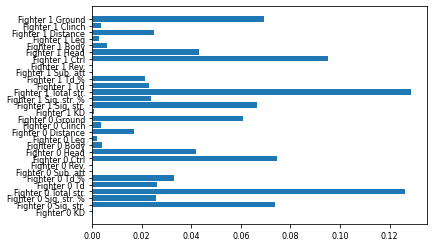

In [1369]:
from sklearn.ensemble import RandomForestClassifier

# Train
random_forest_clf = RandomForestClassifier(max_depth=5, random_state=0)
random_forest_clf.fit(X_train, y_train)

# Validate
accuracy_train = random_forest_clf.score(X_train, y_train)
accuracy_valid = random_forest_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, random_forest_clf.feature_importances_)

               precision    recall  f1-score   support

Fighter 0 Win       1.00      1.00      1.00         1
Fighter 1 Win       1.00      1.00      1.00         1

     accuracy                           1.00         2
    macro avg       1.00      1.00      1.00         2
 weighted avg       1.00      1.00      1.00         2



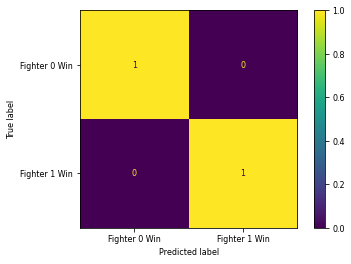

In [1370]:
plot_confusion_matrix(random_forest_clf, X_valid, y_valid)
print_classification_report(random_forest_clf, X_valid, y_valid)

### Extra trees

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


accuracy_train = 1.0
accuracy_valid = 1.0


<BarContainer object of 30 artists>

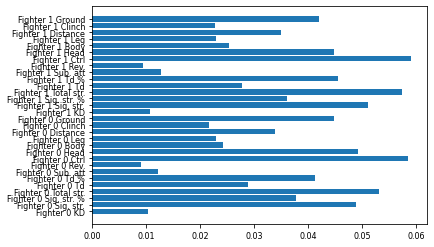

In [1371]:
from sklearn.ensemble import ExtraTreesClassifier

# Train
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
extra_trees_clf.fit(X_train, y_train)

# Validate
accuracy_train = extra_trees_clf.score(X_train, y_train)
accuracy_valid = extra_trees_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, extra_trees_clf.feature_importances_)

               precision    recall  f1-score   support

Fighter 0 Win       1.00      1.00      1.00         1
Fighter 1 Win       1.00      1.00      1.00         1

     accuracy                           1.00         2
    macro avg       1.00      1.00      1.00         2
 weighted avg       1.00      1.00      1.00         2



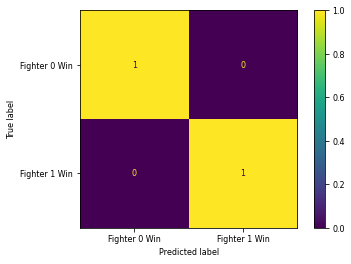

In [1372]:
plot_confusion_matrix(extra_trees_clf, X_valid, y_valid)
print_classification_report(extra_trees_clf, X_valid, y_valid)

### MLP

In [1373]:
# MLP
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
accuracy_train = mlp_clf.score(X_train, y_train)
accuracy_valid = mlp_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.9539865871833085
accuracy_valid = 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


               precision    recall  f1-score   support

Fighter 0 Win       1.00      1.00      1.00         1
Fighter 1 Win       1.00      1.00      1.00         1

     accuracy                           1.00         2
    macro avg       1.00      1.00      1.00         2
 weighted avg       1.00      1.00      1.00         2



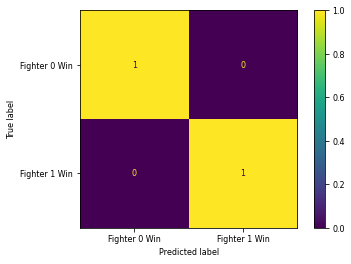

In [1374]:
plot_confusion_matrix(mlp_clf, X_valid, y_valid)
print_classification_report(mlp_clf, X_valid, y_valid)

### SVM

In [1375]:
# SVM
from sklearn.svm import SVC

svm_clf = SVC(random_state=1, probability=True).fit(X_train, y_train)
accuracy_train = svm_clf.score(X_train, y_train)
accuracy_valid = svm_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.882451564828614
accuracy_valid = 1.0


               precision    recall  f1-score   support

Fighter 0 Win       1.00      1.00      1.00         1
Fighter 1 Win       1.00      1.00      1.00         1

     accuracy                           1.00         2
    macro avg       1.00      1.00      1.00         2
 weighted avg       1.00      1.00      1.00         2



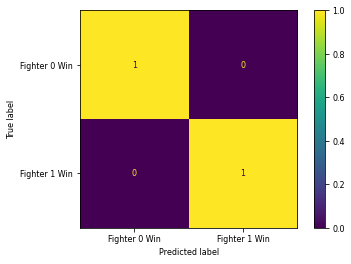

In [1376]:
plot_confusion_matrix(svm_clf, X_valid, y_valid)
print_classification_report(svm_clf, X_valid, y_valid)

In [1377]:
# SVM linear kernel
svm_linear_clf = SVC(kernel='linear', random_state=1, probability=True).fit(X_train, y_train)
accuracy_train = svm_linear_clf.score(X_train, y_train)
accuracy_valid = svm_linear_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.8600968703427719
accuracy_valid = 1.0


<BarContainer object of 30 artists>

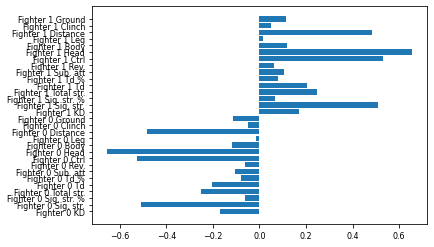

In [1378]:
# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, svm_linear_clf.coef_[0])

               precision    recall  f1-score   support

Fighter 0 Win       1.00      1.00      1.00         1
Fighter 1 Win       1.00      1.00      1.00         1

     accuracy                           1.00         2
    macro avg       1.00      1.00      1.00         2
 weighted avg       1.00      1.00      1.00         2



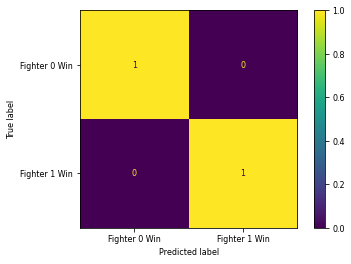

In [1379]:
plot_confusion_matrix(svm_linear_clf, X_valid, y_valid)
print_classification_report(svm_linear_clf, X_valid, y_valid)

In [1380]:
probability0 = svm_linear_clf.predict_proba(X_valid)[0][0]
probability1 = svm_linear_clf.predict_proba(X_valid)[0][1]
print(f"Probability that {fighter0} won: {probability0}")
print(f"Probability that {fighter1} won: {probability1}")
print(f"Actual winner: {fighter0 if y_valid.iloc[0][0] == 0 else fighter1}")

Probability that TJ Dillashaw won: 0.1843428869915624
Probability that Dominick Cruz won: 0.8156571130084374
Actual winner: Dominick Cruz


### XGBoost

In [1381]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

accuracy_train = xgb_clf.score(X_train, y_train)
accuracy_valid = xgb_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.8815201192250373
accuracy_valid = 1.0


               precision    recall  f1-score   support

Fighter 0 Win       1.00      1.00      1.00         1
Fighter 1 Win       1.00      1.00      1.00         1

     accuracy                           1.00         2
    macro avg       1.00      1.00      1.00         2
 weighted avg       1.00      1.00      1.00         2



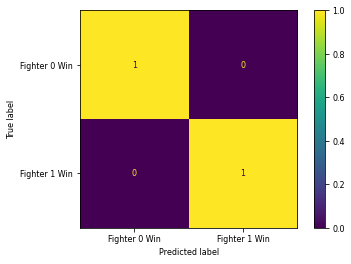

In [1382]:
plot_confusion_matrix(xgb_clf, X_valid, y_valid)
print_classification_report(xgb_clf, X_valid, y_valid)

### Logistic regression

accuracy_train = 0.8617734724292101
accuracy_valid = 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<BarContainer object of 30 artists>

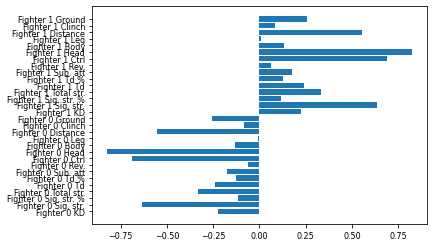

In [1383]:
from sklearn.linear_model import LogisticRegression
logistic_regression_clf = LogisticRegression(random_state=0).fit(X_train, y_train)

accuracy_train = logistic_regression_clf.score(X_train, y_train)
accuracy_valid = logistic_regression_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, logistic_regression_clf.coef_[0])

               precision    recall  f1-score   support

Fighter 0 Win       1.00      1.00      1.00         1
Fighter 1 Win       1.00      1.00      1.00         1

     accuracy                           1.00         2
    macro avg       1.00      1.00      1.00         2
 weighted avg       1.00      1.00      1.00         2



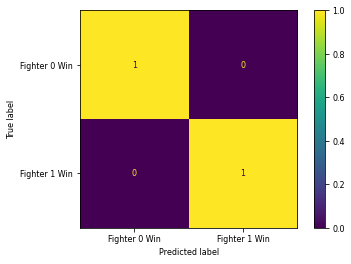

In [1384]:
plot_confusion_matrix(logistic_regression_clf, X_valid, y_valid)
print_classification_report(logistic_regression_clf, X_valid, y_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.860655737704918
accuracy_valid = 1.0


<BarContainer object of 30 artists>

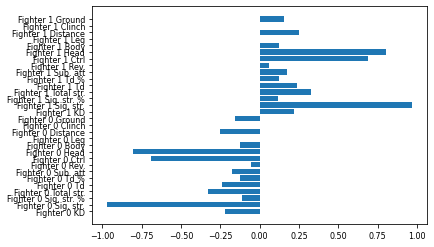

In [1385]:
logistic_regression_l1_clf = LogisticRegression(penalty='l1', solver='liblinear', random_state=0).fit(X_train, y_train)

accuracy_train = logistic_regression_l1_clf.score(X_train, y_train)
accuracy_valid = logistic_regression_l1_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

# Visualize importances
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
plt.barh(X_train.columns, logistic_regression_l1_clf.coef_[0])

               precision    recall  f1-score   support

Fighter 0 Win       1.00      1.00      1.00         1
Fighter 1 Win       1.00      1.00      1.00         1

     accuracy                           1.00         2
    macro avg       1.00      1.00      1.00         2
 weighted avg       1.00      1.00      1.00         2



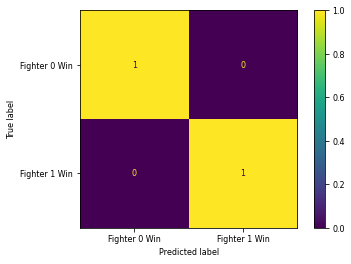

In [1386]:
plot_confusion_matrix(logistic_regression_l1_clf, X_valid, y_valid)
print_classification_report(logistic_regression_l1_clf, X_valid, y_valid)

### KNN classifier

In [1387]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)

accuracy_train = knn_clf.score(X_train, y_train)
accuracy_valid = knn_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


accuracy_train = 0.8517138599105812
accuracy_valid = 1.0


               precision    recall  f1-score   support

Fighter 0 Win       1.00      1.00      1.00         1
Fighter 1 Win       1.00      1.00      1.00         1

     accuracy                           1.00         2
    macro avg       1.00      1.00      1.00         2
 weighted avg       1.00      1.00      1.00         2



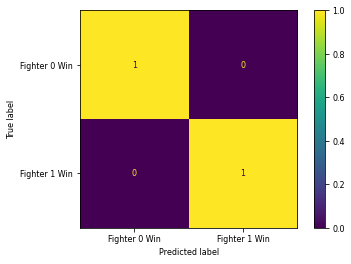

In [1388]:
plot_confusion_matrix(knn_clf, X_valid, y_valid)
print_classification_report(knn_clf, X_valid, y_valid)

### Gradient boosting

In [1389]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_boosting_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)

accuracy_train = gradient_boosting_clf.score(X_train, y_train)
accuracy_valid = gradient_boosting_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.8666169895678092
accuracy_valid = 1.0


               precision    recall  f1-score   support

Fighter 0 Win       1.00      1.00      1.00         1
Fighter 1 Win       1.00      1.00      1.00         1

     accuracy                           1.00         2
    macro avg       1.00      1.00      1.00         2
 weighted avg       1.00      1.00      1.00         2



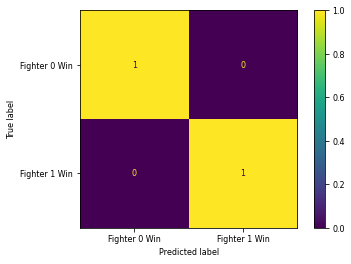

In [1390]:
plot_confusion_matrix(gradient_boosting_clf, X_valid, y_valid)
print_classification_report(gradient_boosting_clf, X_valid, y_valid)

### Adaboost

In [1391]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)

accuracy_train = adaboost_clf.score(X_train, y_train)
accuracy_valid = adaboost_clf.score(X_valid, y_valid)
print(f"accuracy_train = {accuracy_train}")
print(f"accuracy_valid = {accuracy_valid}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_train = 0.8578614008941878
accuracy_valid = 1.0


               precision    recall  f1-score   support

Fighter 0 Win       1.00      1.00      1.00         1
Fighter 1 Win       1.00      1.00      1.00         1

     accuracy                           1.00         2
    macro avg       1.00      1.00      1.00         2
 weighted avg       1.00      1.00      1.00         2



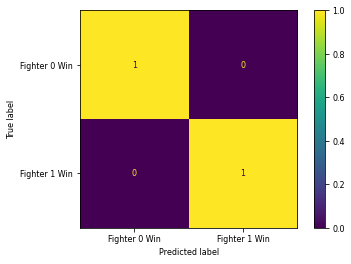

In [1392]:
plot_confusion_matrix(adaboost_clf, X_valid, y_valid)
print_classification_report(adaboost_clf, X_valid, y_valid)

### Comparison Model

In [1393]:
from tensorflow.keras.layers import Input, Lambda, Subtract, Activation
from tensorflow.keras.models import Model
def create_comparison_model(input_shape):
    num_features_per_fighter = input_shape[0] // 2

    model_ = tf.keras.models.Sequential(name="scoring_deep_model")
    model_.add(tf.keras.Input(shape=num_features_per_fighter))
    model_.add(tf.keras.layers.Dense(32, activation='relu'))
    model_.add(tf.keras.layers.Dropout(0.5))
    model_.add(tf.keras.layers.Dense(16, activation='relu'))
    model_.add(tf.keras.layers.Dropout(0.5))

    model_.add(tf.keras.layers.Dense(1, activation='relu'))
    
    # Run cnn model on each frame
    input_tensor = Input(shape=input_shape, name="input")
    fighter0_state = Lambda(lambda x: x[:, :num_features_per_fighter], name='fighter0_state')(input_tensor)
    fighter1_state = Lambda(lambda x: x[:, num_features_per_fighter:], name='fighter1_state')(input_tensor)

    fighter0_score = model_(fighter0_state)
    fighter1_score = model_(fighter1_state)
    fighter0_score = Lambda(lambda x: x, name='fighter0_score')(fighter0_score)
    fighter1_score = Lambda(lambda x: x, name='fighter1_score')(fighter1_score)
    
    difference_score = Subtract(name='subtracter')([fighter1_score, fighter0_score])
    prediction = Activation('sigmoid', name='sigmoid')(difference_score)
    return Model(inputs=input_tensor, outputs=prediction)

In [1394]:
comparison_model = create_comparison_model(X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.001)
comparison_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
comparison_model.summary()

Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 30)]         0                                            
__________________________________________________________________________________________________
fighter1_state (Lambda)         (None, 15)           0           input[0][0]                      
__________________________________________________________________________________________________
fighter0_state (Lambda)         (None, 15)           0           input[0][0]                      
__________________________________________________________________________________________________
scoring_deep_model (Sequential) (None, 1)            1057        fighter0_state[0][0]             
                                                                 fighter1_state[0][0]      

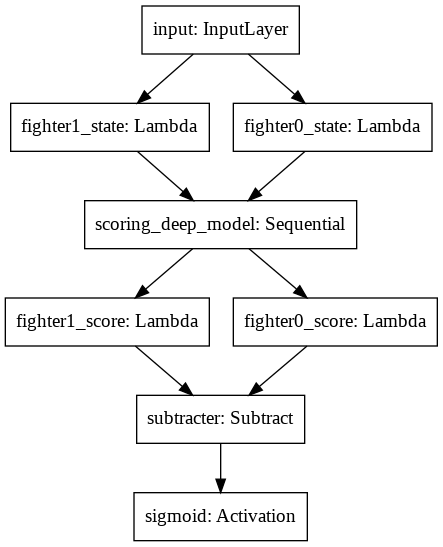

In [1395]:
tf.keras.utils.plot_model(comparison_model)

In [1396]:
H = comparison_model.fit(X_train, y_train, epochs=60, validation_data=(X_valid_new_normal, y_valid))

Epoch 1/60
168/168 [==============================] - 1s 4ms/step - loss: 0.6719 - accuracy: 0.5488 - val_loss: 0.5045 - val_accuracy: 1.0000
Epoch 2/60
168/168 [==============================] - 0s 3ms/step - loss: 0.5633 - accuracy: 0.6904 - val_loss: 0.3270 - val_accuracy: 1.0000
Epoch 3/60
168/168 [==============================] - 0s 3ms/step - loss: 0.5229 - accuracy: 0.7337 - val_loss: 0.3341 - val_accuracy: 1.0000
Epoch 4/60
168/168 [==============================] - 0s 3ms/step - loss: 0.4851 - accuracy: 0.7805 - val_loss: 0.3457 - val_accuracy: 1.0000
Epoch 5/60
168/168 [==============================] - 0s 3ms/step - loss: 0.4658 - accuracy: 0.7848 - val_loss: 0.3228 - val_accuracy: 1.0000
Epoch 6/60
168/168 [==============================] - 0s 3ms/step - loss: 0.4423 - accuracy: 0.8080 - val_loss: 0.3087 - val_accuracy: 1.0000
Epoch 7/60
168/168 [==============================] - 0s 3ms/step - loss: 0.4436 - accuracy: 0.8134 - val_loss: 0.3234 - val_accuracy: 1.0000
Epoch 

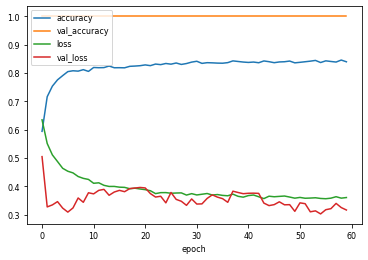

In [1397]:
from matplotlib import pyplot as plt
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'], loc='upper left')
plt.show()

               precision    recall  f1-score   support

Fighter 0 Win       1.00      1.00      1.00         1
Fighter 1 Win       1.00      1.00      1.00         1

     accuracy                           1.00         2
    macro avg       1.00      1.00      1.00         2
 weighted avg       1.00      1.00      1.00         2



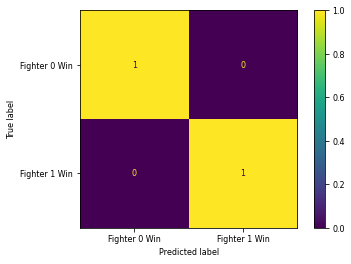

In [1398]:
plot_confusion_matrix(comparison_model, X_valid_new_normal, y_valid)
print_classification_report(comparison_model, X_valid_new_normal, y_valid)

In [1399]:
lo, hi = 0, 1

In [1400]:
X_test_new_normal = X_valid_new_normal

In [1401]:
y_test = y_valid

In [1402]:
X_test_new_normal[lo:hi]

,Fighter 0 KD,Fighter 0 Sig. str.,Fighter 0 Sig. str. %,Fighter 0 Total str.,Fighter 0 Td,Fighter 0 Td %,Fighter 0 Sub. att,Fighter 0 Rev.,Fighter 0 Ctrl,Fighter 0 Head,Fighter 0 Body,Fighter 0 Leg,Fighter 0 Distance,Fighter 0 Clinch,Fighter 0 Ground,Fighter 1 KD,Fighter 1 Sig. str.,Fighter 1 Sig. str. %,Fighter 1 Total str.,Fighter 1 Td,Fighter 1 Td %,Fighter 1 Sub. att,Fighter 1 Rev.,Fighter 1 Ctrl,Fighter 1 Head,Fighter 1 Body,Fighter 1 Leg,Fighter 1 Distance,Fighter 1 Clinch,Fighter 1 Ground
2520,-0.297601,1.974291,-1.309962,1.337119,-0.270446,-0.527104,-0.446372,-0.387715,-0.607473,1.540485,1.309876,1.628677,2.282812,-0.158238,-0.506837,-0.297601,2.073129,-0.442705,1.138032,1.193507,0.194675,-0.446372,-0.387715,-0.796155,3.046853,-0.149087,-0.280022,2.455486,-0.271707,-0.612816


In [1403]:
probability = comparison_model.predict(X_test_new_normal[lo:hi])[0]

In [1404]:
comparison_model.predict(X_test_new_normal[lo:hi])

array([[0.72899663]], dtype=float32)

In [1405]:
y_test[lo:hi]

,Winner
2520,1


In [1406]:
subtracter = comparison_model.get_layer('subtracter').output
subtracter = Model(comparison_model.input, subtracter)
subtracter.predict(X_test_new_normal[lo:hi])

array([[0.9895377]], dtype=float32)

In [1407]:
fighter0_score = comparison_model.get_layer('fighter0_score').output
fighter0_score = Model(comparison_model.input, fighter0_score)
fighter0_score.predict(X_test_new_normal[lo:hi])

array([[3.5869355]], dtype=float32)

In [1408]:
fighter1_score = comparison_model.get_layer('fighter1_score').output
fighter1_score = Model(comparison_model.input, fighter1_score)
fighter1_score.predict(X_test_new_normal[lo:hi])

array([[4.576473]], dtype=float32)

In [1409]:
score0 = fighter0_score.predict(X_test_new_normal[lo:hi])[0][0]
score1 = fighter1_score.predict(X_test_new_normal[lo:hi])[0][0]
prediction = comparison_model.predict(X_test_new_normal[lo:hi])[0][0]
print(f"{fighter0} score: {score0}")
print(f"{fighter1} score: {score1}")
print(f"Probability that {fighter1} won: {prediction}")
print(f"Actual winner: {fighter0 if y_test.iloc[0][0] == 0 else fighter1}")

TJ Dillashaw score: 3.586935520172119
Dominick Cruz score: 4.576473236083984
Probability that Dominick Cruz won: 0.7289966344833374
Actual winner: Dominick Cruz


In [1410]:
controversial

,Fighter 0 KD,Fighter 1 KD,Fighter 0 Sig. str.,Fighter 1 Sig. str.,Fighter 0 Sig. str. %,Fighter 1 Sig. str. %,Fighter 0 Total str.,Fighter 1 Total str.,Fighter 0 Td,Fighter 1 Td,Fighter 0 Td %,Fighter 1 Td %,Fighter 0 Sub. att,Fighter 1 Sub. att,Fighter 0 Rev.,Fighter 1 Rev.,Fighter 0 Ctrl,Fighter 1 Ctrl,Fighter 0 Name,Fighter 1 Name,Fighter 0 Head,Fighter 1 Head,Fighter 0 Body,Fighter 1 Body,Fighter 0 Leg,Fighter 1 Leg,Fighter 0 Distance,Fighter 1 Distance,Fighter 0 Clinch,Fighter 1 Clinch,Fighter 0 Ground,Fighter 1 Ground,Winner,Method
2520,0,0,109,112,26.0,37.0,130,122,1,4,12.0,36.0,0,0,0,0,72.0,33.0,TJ Dillashaw,Dominick Cruz,64,97,22,9,23,6,102,107,6,5,1,0,1,S-DEC


In [1411]:
X_test_new_normal

,Fighter 0 KD,Fighter 0 Sig. str.,Fighter 0 Sig. str. %,Fighter 0 Total str.,Fighter 0 Td,Fighter 0 Td %,Fighter 0 Sub. att,Fighter 0 Rev.,Fighter 0 Ctrl,Fighter 0 Head,Fighter 0 Body,Fighter 0 Leg,Fighter 0 Distance,Fighter 0 Clinch,Fighter 0 Ground,Fighter 1 KD,Fighter 1 Sig. str.,Fighter 1 Sig. str. %,Fighter 1 Total str.,Fighter 1 Td,Fighter 1 Td %,Fighter 1 Sub. att,Fighter 1 Rev.,Fighter 1 Ctrl,Fighter 1 Head,Fighter 1 Body,Fighter 1 Leg,Fighter 1 Distance,Fighter 1 Clinch,Fighter 1 Ground
2520,-0.297601,1.974291,-1.309962,1.337119,-0.270446,-0.527104,-0.446372,-0.387715,-0.607473,1.540485,1.309876,1.628677,2.282812,-0.158238,-0.506837,-0.297601,2.073129,-0.442705,1.138032,1.193507,0.194675,-0.446372,-0.387715,-0.796155,3.046853,-0.149087,-0.280022,2.455486,-0.271707,-0.612816
2520,-0.297601,2.073129,-0.442705,1.138032,1.193507,0.194675,-0.446372,-0.387715,-0.796155,3.046853,-0.149087,-0.280022,2.455486,-0.271707,-0.612816,-0.297601,1.974291,-1.309962,1.337119,-0.270446,-0.527104,-0.446372,-0.387715,-0.607473,1.540485,1.309876,1.628677,2.282812,-0.158238,-0.506837


In [1412]:
# 
columns = list(X_test_new_normal.columns)
new_columns = columns[len(columns)//2:] + columns[:len(columns)//2]
switcheroo = X_test_new_normal[new_columns]
fighter1_score.predict(switcheroo[lo:hi])

array([[3.5869355]], dtype=float32)

In [1413]:
fighter0_score.predict(switcheroo[lo:hi])

array([[4.576473]], dtype=float32)

In [1414]:
subtracter.predict(switcheroo[lo:hi])

array([[-0.9895377]], dtype=float32)

In [1415]:
comparison_model.predict(switcheroo[lo:hi])

array([[0.2710034]], dtype=float32)

In [1416]:
deep_model.predict(X_test_new_normal[1:10])

array([[0.09779119]], dtype=float32)

In [1417]:
deep_model.predict(switcheroo[1:10])

array([[0.07187624]], dtype=float32)